# OIC-Grid: Clustering multiagente

**Asignatura:** Sistemas Multiagente 

**Autor:** Juan Esteban Rincón Marín

**Objetivo:** Evaluar un algoritmo de clustering inspirado en el proceso de opsonización del sistema inmune sobre datasets clásicos, utilizando métricas externas e internas estándar. Se ha dado con el nombre tan original de **Opsozation-Inspired Clustering**, abreviado en **OIC**

Este notebook contiene **toda la implementación y evaluación**, organizada por secciones temáticas para facilitar su lectura y evaluación.

## Datasets seleccionados

Para la validación experimental del algoritmo de clustering propuesto se han seleccionado los datasets **Iris** y **Wine**, ambos ampliamente utilizados como benchmarks en la literatura científica sobre clustering y aprendizaje no supervisado.

### Iris
El dataset Iris contiene 150 instancias descritas por 4 variables numéricas continuas, distribuidas en 3 clases reales. Su tamaño reducido y estructura bien estudiada lo convierten en un conjunto de datos idóneo para validar el comportamiento inicial de algoritmos de clustering y facilitar la interpretación de los resultados.

### Wine
El dataset Wine está compuesto por 178 instancias con 13 variables numéricas, también organizadas en 3 clases reales. Presenta una mayor dimensionalidad y complejidad que Iris, lo que permite evaluar la robustez del algoritmo frente a espacios de características más ricos.

Ambos datasets incluyen etiquetas reales que **no se utilizan durante el proceso de clustering**, sino exclusivamente para la evaluación posterior mediante métricas externas, siguiendo el enfoque estándar en aprendizaje no supervisado.

## Métricas de evaluación

La evaluación del rendimiento del algoritmo se realiza combinando métricas externas e internas, con el objetivo de analizar tanto la correspondencia con las clases reales como la calidad estructural de los clusters obtenidos.

### Métricas externas

**Adjusted Rand Index (ARI)**  
Se utiliza como métrica principal para medir la similitud entre el clustering obtenido y las etiquetas reales. El índice está ajustado por azar, lo que permite una comparación robusta entre diferentes configuraciones y evita sesgos derivados de asignaciones aleatorias.

**Normalized Mutual Information (NMI)**  
Se emplea como métrica principal complementaria al ARI. Evalúa la cantidad de información compartida entre la partición obtenida y las clases reales, y es especialmente adecuada para comparar particiones independientemente de la permutación de etiquetas.

### Métricas internas

**Silhouette Score**  
Se utiliza como métrica interna de apoyo para evaluar la cohesión interna de los clusters y su separación relativa, sin hacer uso de información externa. Permite analizar la calidad geométrica de la partición resultante.

**Davies–Bouldin Index**  
Se emplea como métrica interna complementaria al Silhouette Score. Mide la relación entre la dispersión intra-cluster y la separación inter-cluster, siendo valores más bajos indicativos de una mejor estructura de clustering.

La combinación de métricas externas e internas permite una evaluación más completa del algoritmo, evitando depender de un único criterio y alineándose con las prácticas habituales en la literatura científica.

# 1. Imports y configuración global

In [1]:
# IMPORTS

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import List, Tuple, Optional
from itertools import product
from copy import deepcopy

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# CONSTANTES GLOBALES

UNASSIGNED = -1

# 2. Implementación mínima del algoritmo OIC con su calculo de metricas online y la aplicación de metricas internas y externas
En esta sección se incluyen la definición de funciones de ayuda, dataclasses y la definición de la clase del algoritmo con su función fit().
Posteriormente se definen funciones para calcular metricas offline y metricas online del algortimo, asi como la funcion fit_predict().

## 2.1. Utilidades geométricas y operaciones sobre el grid
En esta sección se agrupan funciones auxiliares **independientes del algoritmo**, relacionadas con:
- distancias
- vecindarios
- movimiento en grid
- búsqueda de celdas libres

No contienen lógica de clustering.

In [2]:
def chebyshev_distance(p1: Tuple[int, int], p2: Tuple[int, int]) -> int:
    """Calcula la distancia de Chebyshev entre dos posiciones."""
    # Distancia L inf para vecindarios tipo Moore.
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))


def get_neighborhood(center: Tuple[int, int], radius: int, grid) -> List[Tuple[int, int]]:
    """Devuelve las celdas válidas dentro de un radio Chebyshev."""
    # Explora el cuadrado (2r+1)x(2r+1) alrededor del centro.
    cx, cy = center
    cells: List[Tuple[int, int]] = []
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            pos = (cx + dx, cy + dy)
            if grid.is_valid(pos):
                cells.append(pos)
    return cells


def ordered_objects_in_cells(
    cells: List[Tuple[int, int]],
    grid,
    objects: List
) -> List:
    """Obtiene los objetos presentes en las celdas en orden determinista."""
    # Orden de lectura por filas: (y, x).
    sorted_cells = sorted(cells, key=lambda pos: (pos[1], pos[0]))

    obj_by_id = {obj.object_id: obj for obj in objects}
    found: List = []

    for cell in sorted_cells:
        obj_id = grid.get_cell(cell)
        if obj_id is not None and obj_id in obj_by_id:
            found.append(obj_by_id[obj_id])

    return found


def random_walk_step_8dir(
    pos: Tuple[int, int],
    grid,
    rng: np.random.Generator
) -> Tuple[int, int]:
    """Da un paso aleatorio válido en 8 direcciones."""
    # Movimiento exploratorio sin objetivo.
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]

    valid_moves: List[Tuple[int, int]] = []
    x, y = pos
    for dx, dy in directions:
        npos = (x + dx, y + dy)
        if grid.is_valid(npos):
            valid_moves.append(npos)

    if not valid_moves:
        return pos

    return valid_moves[int(rng.integers(0, len(valid_moves)))]


def greedy_step_minimize_dinf(
    current: Tuple[int, int],
    target: Tuple[int, int],
    grid
) -> Tuple[int, int]:
    """Da un paso que minimiza la distancia de Chebyshev al objetivo."""
    # Movimiento reactivo hacia el objetivo más cercano.
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]

    best_pos = current
    best_dist = chebyshev_distance(current, target)

    cx, cy = current
    for dx, dy in directions:
        npos = (cx + dx, cy + dy)
        if grid.is_valid(npos):
            d = chebyshev_distance(npos, target)
            if d < best_dist:
                best_dist = d
                best_pos = npos

    return best_pos


def nearest_free_cell_by_increasing_radius(
    center: Tuple[int, int],
    grid,
    max_radius: int = 50
) -> Optional[Tuple[int, int]]:
    """Busca la celda libre más cercana ampliando el radio progresivamente."""
    # Búsqueda radial determinista alrededor del centro.
    for r in range(0, max_radius + 1):
        cells = get_neighborhood(center, r, grid)
        cells.sort(key=lambda p: (chebyshev_distance(p, center), p[1], p[0]))

        for cell in cells:
            if grid.is_free(cell):
                return cell

    return None

## 2.2. Entidades del sistema multiagente
Aquí se definen las estructuras de datos que representan el estado del sistema:
- Objetos a clasificar
- Balizas (beacons)
- Agentes (marcadores y transportadores)
- Grid y estado global

No se ejecuta el algoritmo en esta sección.

In [3]:
@dataclass
class Beacon:
    """Baliza que representa un clúster y su prototipo."""
    cluster_id: int
    grid_pos: Tuple[int, int]
    prototype: np.ndarray
    count: int = 1

    def update_prototype(self, new_object: np.ndarray) -> None:
        """Actualiza el prototipo usando media incremental."""
        self.count += 1
        self.prototype += (new_object - self.prototype) / self.count


@dataclass
class GridObject:
    """Objeto de datos situado en el grid."""
    object_id: int
    features: np.ndarray
    grid_pos: Tuple[int, int]
    label: int = 0  # 0 significa sin asignar
    discarded: bool = False # Esto evita que se vuelva a recoger


class Grid:
    """Grid 2D que almacena la ocupación por celda."""
    
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        # occupancy[y][x] contiene object_id o None
        self.occupancy: List[List[Optional[int]]] = [
            [None for _ in range(width)] for _ in range(height)
        ]

    def is_valid(self, pos: Tuple[int, int]) -> bool:
        """Comprueba si una posición está dentro del grid."""
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height

    def is_free(self, pos: Tuple[int, int]) -> bool:
        """Indica si una celda válida está libre."""
        if not self.is_valid(pos):
            return False
        x, y = pos
        return self.occupancy[y][x] is None

    def set_cell(self, pos: Tuple[int, int], obj_id: Optional[int]) -> None:
        """Ocupa o libera una celda del grid."""
        x, y = pos
        self.occupancy[y][x] = obj_id

    def get_cell(self, pos: Tuple[int, int]) -> Optional[int]:
        """Devuelve el object_id almacenado en una celda."""
        x, y = pos
        return self.occupancy[y][x]


@dataclass
class MarkerAgent:
    """Agente que crea balizas y etiqueta objetos."""
    agent_id: int
    grid_pos: Tuple[int, int]


@dataclass
class TransporterAgent:
    """Agente que transporta objetos entre celdas."""
    agent_id: int
    grid_pos: Tuple[int, int]
    carrying: Optional[int] = None

## 2.3. Algoritmo OIC-Grid
Esta sección implementa el núcleo del algoritmo de clustering multiagente.
Incluye la dinámica de los agentes, la creación y uso de balizas y la lógica
de asignación de etiquetas.

No incluye métricas ni evaluación experimental.

In [4]:
class OICGrid:
    """Clustering inspirado en opsonización sobre un grid 2D."""

    def __init__(
        self,
        grid_scale: float = 4.0,
        object_radius: int = 1,
        beacon_radius: int = 5,
        local_beacon_cap: int = 3,
        n_marker_agents: int = 5,
        n_transporter_agents: int = 5,
        seed_object_placement: int = 42,
        seed_agent_walk: int = 43,
        seed_tau_calculator: int = 44,
        tau_percentile: int = 15,
        tau_sample_ratio: float = 1.0
    ):
        """Configura el grid, los radios, la capacidad local, los agentes y las semillas."""
        self.lambda_grid = grid_scale
        self.r_obj = object_radius
        self.r_beacon = beacon_radius
        self.k_local = local_beacon_cap

        self.n_markers = n_marker_agents
        self.n_transporters = n_transporter_agents

        self.rng_place = np.random.default_rng(seed_object_placement)
        self.rng_walk = np.random.default_rng(seed_agent_walk)
        self.rng_tau = np.random.default_rng(seed_tau_calculator)

        self.objects: List[GridObject] = []
        self.beacons: List[Beacon] = []
        self.grid: Optional[Grid] = None
        self.markers: List[MarkerAgent] = []
        self.transporters: List[TransporterAgent] = []
        self.tau: float = 0.0
        self.tau_percentile: int = tau_percentile
        self.tau_sample_ratio: float = tau_sample_ratio

        self.states = []

    def normalize(self, X: np.ndarray) -> np.ndarray:
        """Normaliza las features con z-score."""
        return StandardScaler().fit_transform(X)

    def compute_tau(
        self,
        X: np.ndarray,
        percentile: float = 15.0,
        sample_ratio: float = 1.0,
        rng: Optional[np.random.Generator] = None,
    ) -> float:
        """Calcula τ como percentil de distancias usando una fracción de pares."""
        n = len(X)
        pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

        if sample_ratio < 1.0:
            rng = rng or np.random.default_rng()
            pairs = rng.choice(pairs, size=int(len(pairs) * sample_ratio), replace=False)

        d = [np.linalg.norm(X[i] - X[j]) for i, j in pairs]
        return float(np.percentile(d, percentile))


    def init_grid(self) -> Grid:
        """Crea el grid y posiciona los objetos."""
        n = len(self.objects)
        size = int(self.lambda_grid * n)
        w = int(np.ceil(np.sqrt(size)))
        h = int(np.ceil(size / w))

        grid = Grid(w, h)
        cells = [(x, y) for x in range(w) for y in range(h)]
        self.rng_place.shuffle(cells)

        for obj, pos in zip(self.objects, cells):
            obj.grid_pos = pos
            grid.set_cell(pos, obj.object_id)

        return grid

    def init_agents(self) -> None:
        """Inicializa marcadores y transportadores."""
        for i in range(self.n_markers):
            pos = (
                self.rng_place.integers(0, self.grid.width),
                self.rng_place.integers(0, self.grid.height),
            )
            self.markers.append(MarkerAgent(i, pos))

        for i in range(self.n_transporters):
            pos = (
                self.rng_place.integers(0, self.grid.width),
                self.rng_place.integers(0, self.grid.height),
            )
            self.transporters.append(TransporterAgent(i, pos))

    def _visible_beacons(self, pos: Tuple[int, int]) -> List[Beacon]:
        """Devuelve las balizas visibles desde una posición."""
        return [
            b for b in self.beacons
            if chebyshev_distance(b.grid_pos, pos) <= self.r_beacon
        ]

    def _create_beacon(self, obj: GridObject) -> Beacon:
        """Crea una nueva baliza asociada a un objeto."""
        beacon = Beacon(
            cluster_id=len(self.beacons) + 1,
            grid_pos=obj.grid_pos,
            prototype=obj.features.copy(),
        )
        self.beacons.append(beacon)
        return beacon

    def _marker_step(self, marker: MarkerAgent) -> None:
        """Ejecuta un paso de un marcador."""
        cells = get_neighborhood(marker.grid_pos, self.r_obj, self.grid)
        objs = ordered_objects_in_cells(cells, self.grid, self.objects)

        unlabeled = [o for o in objs if o.label == 0 and not o.discarded]
        if not unlabeled:
            marker.grid_pos = random_walk_step_8dir(marker.grid_pos, self.grid, self.rng_walk)
            return

        obj = unlabeled[0]
        visibles = self._visible_beacons(obj.grid_pos)

        if not visibles:
            obj.label = self._create_beacon(obj).cluster_id
        else:
            dists = [np.linalg.norm(obj.features - b.prototype) for b in visibles]
            idx = int(np.argmin(dists))
            closest = visibles[idx]

            if dists[idx] <= self.tau or len(visibles) >= self.k_local:
                obj.label = closest.cluster_id
                closest.update_prototype(obj.features)
            else:
                obj.label = self._create_beacon(obj).cluster_id

        marker.grid_pos = random_walk_step_8dir(marker.grid_pos, self.grid, self.rng_walk)

    def _transporter_step(self, transporter: TransporterAgent) -> None:
        """Ejecuta un paso de un transportador."""
        if transporter.carrying is None:
            cells = get_neighborhood(transporter.grid_pos, self.r_obj, self.grid)
            objs = ordered_objects_in_cells(cells, self.grid, self.objects)
            labeled = [o for o in objs if o.label != 0 and not o.discarded]

            if not labeled:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            obj = labeled[0]
            transporter.carrying = obj.object_id
            self.grid.set_cell(obj.grid_pos, None)

        else:
            obj = self.objects[transporter.carrying]
            beacon = next(b for b in self.beacons if b.cluster_id == obj.label)

            if chebyshev_distance(transporter.grid_pos, beacon.grid_pos) > self.r_beacon:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            cell = nearest_free_cell_by_increasing_radius(beacon.grid_pos, self.grid)
            if cell is None:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            transporter.grid_pos = greedy_step_minimize_dinf(
                transporter.grid_pos, cell, self.grid
            )

            if transporter.grid_pos == cell:
                obj.grid_pos = cell
                obj.discarded = True
                self.grid.set_cell(cell, obj.object_id)
                transporter.carrying = None


    def fit(
            self,
            X: np.ndarray,
            iterations: int = 500,
            record_states: bool = True,
            record_every: int = 1,
        ) -> "OICGrid":
            """Entrena el algoritmo durante un número fijo de iteraciones."""
            Xn = self.normalize(X)
            self.tau = self.compute_tau(Xn, percentile = self.tau_percentile, sample_ratio = self.tau_sample_ratio, rng= self.rng_tau)

            self.objects = [GridObject(i, Xn[i], (0, 0)) for i in range(len(Xn))]
            self.grid = self.init_grid()
            self.init_agents()

            agents = self.markers + self.transporters

            if record_states:
                self.states.append({
                    "objects": deepcopy(self.objects),
                    "beacons": deepcopy(self.beacons),
                    "markers": deepcopy(self.markers),
                    "transporters": deepcopy(self.transporters),
                    "grid_size": (self.grid.width, self.grid.height),
                })

            for it in range(iterations):
                for a in agents:
                    if isinstance(a, MarkerAgent):
                        self._marker_step(a)
                    else:
                        self._transporter_step(a)

                if record_states and (it % record_every == 0):
                    self.states.append({
                        "objects": deepcopy(self.objects),
                        "beacons": deepcopy(self.beacons),
                        "markers": deepcopy(self.markers),
                        "transporters": deepcopy(self.transporters),
                        "grid_size": (self.grid.width, self.grid.height),
                    })

            return self

    def get_labels(self) -> np.ndarray:
        """Devuelve las etiquetas finales."""
        return np.array([o.label for o in self.objects])

## 2.4. Métricas de evaluación del clustering
En esta sección se implementan las métricas utilizadas para evaluar los resultados:
- Métricas externas (ARI, NMI)
- Métricas internas (Silhouette, Davies–Bouldin)

Las métricas se calculan **ignorando los objetos no asignados (-1)**.

In [5]:
def compute_metrics(X, y_pred, y_true=None):
    """Calcula métricas offline con política cerrada de no asignados."""
    X = np.asarray(X)
    y_pred = np.asarray(y_pred, dtype=int)

    mask = (y_pred != UNASSIGNED)
    n = len(y_pred)
    n_assigned = int(mask.sum())
    coverage_final = n_assigned / n if n > 0 else 0.0

    out = {
        "coverage_final": coverage_final,
        "n_assigned": n_assigned,
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "ari": np.nan,
        "nmi": np.nan,
    }

    if n_assigned < 2:
        return out

    X_a = X[mask]
    y_a = y_pred[mask]
    k = len(np.unique(y_a))
    
    # metricas internas
    if k >= 2:
        out["silhouette"] = float(silhouette_score(X_a, y_a))
        out["davies_bouldin"] = float(davies_bouldin_score(X_a, y_a))
    
    # metricas externas
    if y_true is not None:
        y_true = np.asarray(y_true)
        if k >= 2:
            out["ari"] = float(adjusted_rand_score(y_true[mask], y_a))
            out["nmi"] = float(normalized_mutual_info_score(y_true[mask], y_a))

    return out

## 2.5. Métricas online durante la ejecución
Además de las métricas finales, se registran métricas durante la ejecución
del algoritmo para analizar su dinámica interna, tales como:
- cobertura de clasificación
- tasa de cambio de etiquetas
- movimiento de objetos

In [6]:
def build_online_log(states, n: int):
    """Construye métricas online a partir de los estados guardados."""
    log = {
        "coverage": [],
        "relabel_rate": [],
        "move_rate": [],
    }

    prev_labels = None
    prev_pos = None

    for t, st in enumerate(states):
        objs = st["objects"]
        labels = np.array(
            [o.label if o.label != 0 else UNASSIGNED for o in objs],
            dtype=int
        )
        coverage = float(np.mean(labels != UNASSIGNED))
        log["coverage"].append(coverage)

        if prev_labels is None:
            log["relabel_rate"].append(0.0)
        else:
            log["relabel_rate"].append(float(np.mean(labels != prev_labels)))

        pos = {o.object_id: o.grid_pos for o in objs}
        if prev_pos is None:
            log["move_rate"].append(0.0)
        else:
            moved = sum(1 for i in pos if pos[i] != prev_pos.get(i, pos[i]))
            log["move_rate"].append(float(moved / n))

        prev_labels = labels
        prev_pos = pos
    return log

## 2.6. Visualización de resultados

Funciones para graficar métricas online y animar el proceso de clustering:

**`plot_online_curves()`**: Genera gráficas de coverage y move_rate a lo largo del tiempo.

**`animate()`**: Crea animación del grid mostrando:
- Puntos coloreados por cluster
- Cruces negras (balizas)
- Triángulos azules (marcadores)
- Cuadrados rojos (transportadores)

In [7]:
def plot_online_curves(online_log: dict):
    """Grafica coverage y move_rate para una ejecución representativa."""
    t = np.arange(len(online_log["coverage"]))

    plt.figure()
    plt.plot(t, online_log["coverage"])
    plt.title("Coverage(t)")
    plt.xlabel("t")
    plt.ylabel("coverage")

    plt.figure()
    plt.plot(t, online_log["move_rate"])
    plt.title("Move rate(t)")
    plt.xlabel("t")
    plt.ylabel("move_rate")

    plt.show()
    
def draw_state(ax, state):
    """Dibuja objetos, balizas y agentes."""
    ax.clear()

    # Objetos
    ox = [o.grid_pos[0] for o in state["objects"]]
    oy = [o.grid_pos[1] for o in state["objects"]]
    labels = [o.label for o in state["objects"]]
    ax.scatter(ox, oy, c=labels, cmap="tab10", s=30, alpha=0.7)

    # Balizas
    if state["beacons"]:
        bx = [b.grid_pos[0] for b in state["beacons"]]
        by = [b.grid_pos[1] for b in state["beacons"]]
        ax.scatter(bx, by, c="black", marker="x", s=120, linewidths=2)

    # Marcadores
    mx = [m.grid_pos[0] for m in state["markers"]]
    my = [m.grid_pos[1] for m in state["markers"]]
    ax.scatter(mx, my, c="blue", marker="^", s=80)

    # Transportadores
    tx = [t.grid_pos[0] for t in state["transporters"]]
    ty = [t.grid_pos[1] for t in state["transporters"]]
    ax.scatter(tx, ty, c="red", marker="s", s=80)

    w, h = state["grid_size"]
    ax.set_xlim(-1, w)
    ax.set_ylim(-1, h)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    
def animate(states, interval=200):
    """Animación inline del algoritmo."""
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(i):
        draw_state(ax, states[i])
        ax.set_title(f"Iteración {i}")

    anim = FuncAnimation(
        fig,
        update,
        frames=len(states),
        interval=interval
    )

    plt.close(fig)
    return HTML(anim.to_jshtml())

# 3. Evaluación experimental en datasets benchmark

## 3.1. Dataset Iris

Aplicación del algoritmo sobre el dataset Iris con los mejores parámetros encontrados.

In [8]:
# Cargar dataset IRIS
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Mejores parámetros para Iris
best_params_iris = {
    'grid_scale': 4.0,
    'beacon_radius': 12,
    'local_beacon_cap': 3,
    'n_marker_agents': 5,
    'n_transporter_agents': 5,
    'tau_percentile': 25,
    'tau_sample_ratio': 1.0,
}

iterations = 500
seed = 7

# Ejecutar solo para visualización
oic_iris = OICGrid(
    **best_params_iris,
    seed_object_placement=seed,
    seed_agent_walk=seed,
    seed_tau_calculator=seed,
)

oic_iris.fit(
    X_iris,
    iterations=iterations,
    record_states=True,
    record_every=1,
)

# Calcular métricas finales
labels_iris = oic_iris.get_labels()
labels_iris = np.where(labels_iris == 0, UNASSIGNED, labels_iris)
metrics_iris = compute_metrics(X_iris, labels_iris, y_iris)

print("Métricas finales Iris:")
for k, v in metrics_iris.items():
    print(f"  {k}: {v}")

Métricas finales Iris:
  coverage_final: 0.9733333333333334
  n_assigned: 146
  silhouette: -0.013303520624475538
  davies_bouldin: 5.9931982886517225
  ari: 0.25859092634462727
  nmi: 0.44279402831431236


### Métricas online - Iris

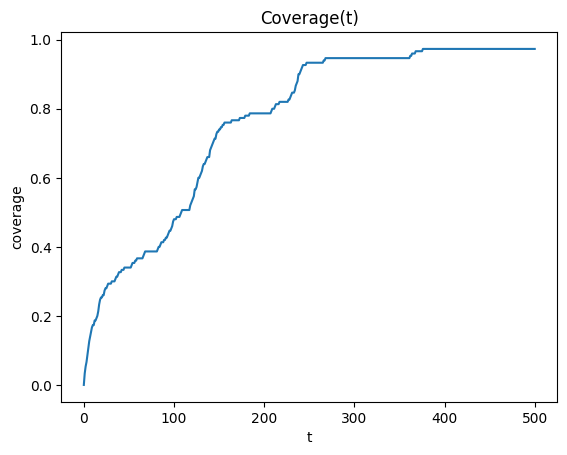

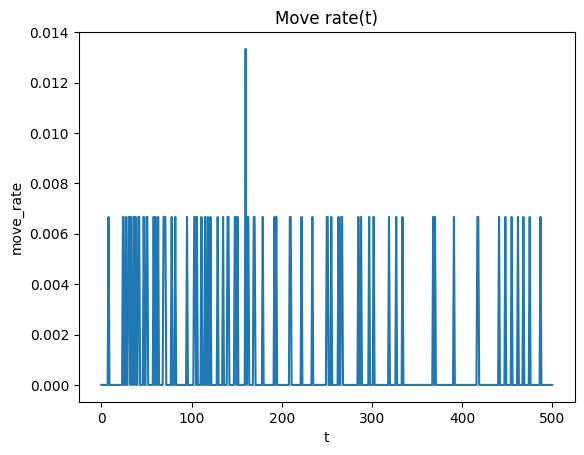

In [9]:
# Visualizar métricas online
online_log_iris = build_online_log(oic_iris.states, len(X_iris))
plot_online_curves(online_log_iris)

### Visualización animada del proceso (Iris)

Se genera la animación completa que muestra:
- La distribución inicial aleatoria de objetos
- El movimiento de los agentes marcadores (triángulos azules)
- El movimiento de los transportadores (cuadrados rojos)
- La creación de balizas (cruces negras)
- La formación gradual de clusters
- El transporte de objetos hacia sus clusters correspondientes

In [ ]:
# Permitir animaciones grandes
mpl.rcParams["animation.embed_limit"] = 300  # MB

# Animación
animate(oic_iris.states)

## 3.2. Dataset Wine

Aplicación del algoritmo sobre el dataset Wine con los mejores parámetros encontrados.

In [11]:
# Cargar dataset WINE
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

# Mejores parámetros para Wine
best_params_wine = {
    'grid_scale': 4.0,
    'beacon_radius': 12,
    'local_beacon_cap': 3,
    'n_marker_agents': 5,
    'n_transporter_agents': 5,
    'tau_percentile': 25,
    'tau_sample_ratio': 1.0,
}

iterations = 500
seed = 16

# Ejecutar solo para visualización
oic_wine = OICGrid(
    **best_params_wine,
    seed_object_placement=seed,
    seed_agent_walk=seed,
    seed_tau_calculator=seed,
)

oic_wine.fit(
    X_wine,
    iterations=iterations,
    record_states=True,
    record_every=1,
)

# Calcular métricas finales
labels_wine = oic_wine.get_labels()
labels_wine = np.where(labels_wine == 0, UNASSIGNED, labels_wine)
metrics_wine = compute_metrics(X_wine, labels_wine, y_wine)

print("Métricas finales Wine:")
for k, v in metrics_wine.items():
    print(f"  {k}: {v}")

Métricas finales Wine:
  coverage_final: 0.9662921348314607
  n_assigned: 172
  silhouette: -0.4979218031019225
  davies_bouldin: 11.10350143860087
  ari: 0.20316273115495076
  nmi: 0.3828497636619212


### Métricas online - Wine

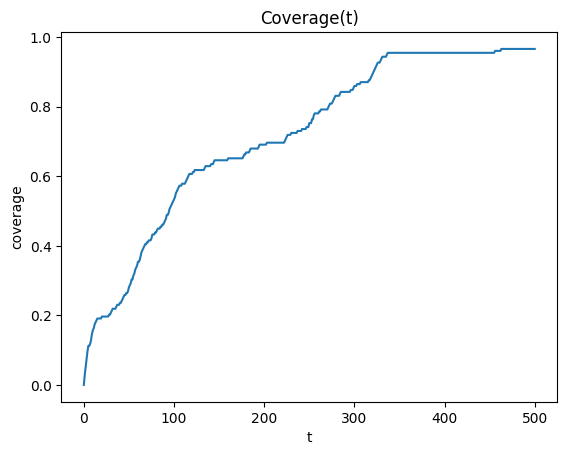

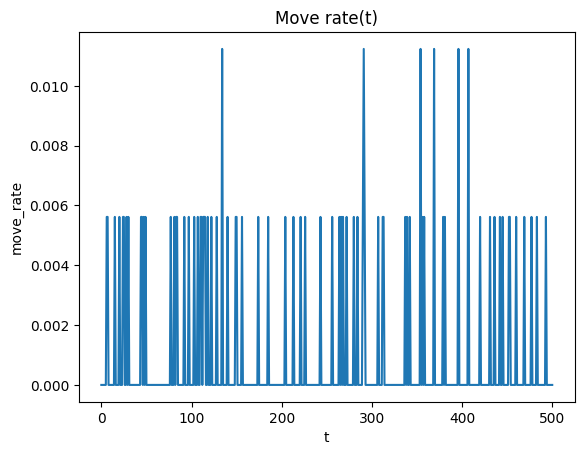

In [12]:
# Visualizar métricas online
online_log_wine = build_online_log(oic_wine.states, len(X_wine))
plot_online_curves(online_log_wine)

### Visualización animada del proceso (Wine)

Animación equivalente usando la mejor configuración para Wine.

Permite comparar visualmente el comportamiento del algoritmo en datasets de distinta complejidad dimensional.

In [ ]:
# Permitir animaciones grandes
mpl.rcParams["animation.embed_limit"] = 300  # MB

# Animación
animate(oic_wine.states)